# Extract CO2 fertilisation effect from OzFlux GPP sites


In [1]:
%matplotlib inline

import os
import sys
import pickle
import warnings
import scipy.stats
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.geo.geom import Geometry
from scipy.signal import detrend
from scipy.stats import theilslopes, kendalltau
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression

# sys.path.append('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/src')

## Analysis Parameters

In [2]:
model_var = 'GPP'
# base = '/g/data/xc0/project/AusEFlux/data/training_data/'
# base = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/data/training_data/'
base = '/g/data/xc0/project/AusEFlux/data/training_data_1km/'
covar_file = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/covars.nc'

## Function to filter for complete years

In [3]:
def filter_complete_years(dff):
    # Extract year and month information
    df = dff.reset_index(drop=False)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    
    # Identify years with all 12 months
    complete_years = (
        df.groupby('year')['month']
        .nunique()
        .loc[lambda x: x == 12]  # Keep only years with exactly 12 unique months
        .index
    )

    # Filter the data array to include only these complete years
    filtered_data = dff.loc[dff.index.year.isin(complete_years)]
    
    return filtered_data

## Loop through flux tower sites

In [4]:
covars = xr.open_dataset(covar_file).drop_vars(['wcf','smrz'])

In [5]:
sites = os.listdir(f'{base}')
exclusions= ['Fletcherview','Loxton', 'FoggDam','Collie','WallabyCreek',
             'RedDirtMelonFarm','SilverPlains','Otway']
flux_ts = {}
for site in sites:
    if '.csv' in site:
        if any(h in site for h in exclusions):
            continue
        else:
            print(site[0:-4])
            df = pd.read_csv(f'{base}{site}',index_col='time', parse_dates=True)
    
            #make sure flux tower doesn't extend beyond covars time range
            mask = (df.index > '2003-1-1') & (df.index <= '2022-12-31')
            df = df.loc[mask]

            #---------test with higher res training data-----------------
            vars = ['GPP_SOLO_EC','rain_RS', 'SRAD_RS', 'Tavg_RS', 'VPD_RS', 'x_coord', 'y_coord']
            df = df[vars]
            df = df.rename({"GPP_SOLO_EC":model_var, 'rain_RS':'rain',
                           'SRAD_RS':'srad','Tavg_RS':'tavg','VPD_RS':'vpd'},
                           axis=1)

            #------------------------------------------------------------
            #keep just the data we need
            # df = df[['GPP_SOLO_EC', 'fPAR_RS', 'x_coord', 'y_coord']]
            # df = df.rename({"GPP_SOLO_EC":'GPP', 'fPAR_RS':'fPAR'},axis=1)
            
            # select nearest pixel to flux tower
            time_start = str(np.datetime_as_string(df.index[0].to_numpy(), unit='D'))
            time_end = str(np.datetime_as_string(df.index[-1].to_numpy(), unit='D'))
            idx=dict(latitude=df.y_coord.iloc[0],longitude=df.x_coord.iloc[0])
            covars_sel = covars['cwd'].sel(idx, method='nearest').sel(time=slice(time_start, time_end)) # grab pixel
            covars_sel = covars_sel.reindex(time=df.index.to_numpy(), method='nearest', tolerance='1D').compute() 
            
            #join covars onto flux data
            df = df.join(covars_sel.drop_vars('spatial_ref').to_dataframe())
            df = df.drop(['x_coord', 'y_coord', 'latitude', 'longitude'], axis=1)
            
            #remove incomplete years
            df = filter_complete_years(df)
            
            rain = df['rain'].resample('YS').sum()
            gpp = df[model_var].resample('YS').sum()
            # fpar = df['fPAR'].resample('YS').sum()
            
            df = df.drop([model_var,'rain'],axis=1).resample('YS').mean()
            df['rain'] = rain
            df[model_var] = gpp
            # df['fPAR'] = fpar

            co2 =  xr.open_dataset(covar_file)['co2']
            co2 = co2.mean(['latitude', 'longitude']).resample(time='YS').mean().drop_vars('spatial_ref').to_dataframe(name='co2')
            df['co2'] = co2
            
            if len(df) < 10:
                continue
            else:   
                flux_ts[site[0:-4]] = df


CowBay
DryRiver
SamfordEcologicalResearchFacility
WombatStateForest
Gingin
Whroo
CalperumChowilla
CumberlandPlain
Tumbarumba
Ridgefield
Boyagin
HowardSprings
DalyPasture
Emerald
RiggsCreek
Litchfield
SturtPlains
LongreachMitchellGrassRangeland
AliceSpringsMulga
CapeTribulation
DalyUncleared
GreatWesternWoodlands
Warra
TiTreeEast
RobsonCreek
Yanco


## Testing implementing GPP residual method

Following [Zhan et al 2024](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023JG007910)



### Steps 1 and 2

In [6]:
beta_dfs = {}
beta_relative_dfs = {}
beta_apparent_dfs = {}
p_values_dfs = {}

for site, df in flux_ts.items():

    for v in [model_var,'rain','srad','tavg','vpd', 'cwd', 'co2']:
        df[f'{v}_detrend'] = detrend(df[v])
        df[f'{v}_detrend'] = df[f'{v}_detrend'] + df[v].median() # add back median
    
    #fit a model
    x = df[['rain_detrend', 'srad_detrend', 'tavg_detrend', 'vpd_detrend', 'cwd_detrend']] #detrended data
    xx = df[['rain', 'srad', 'tavg', 'vpd', 'cwd']] # original data
    y = df[f'{model_var}_detrend']
    
    #fit a RF model using detrended values
    rf = RandomForestRegressor(n_estimators=100, random_state=2).fit(x, y)
    
    ## predict using original climate data (add suffix to trick scikit learn)
    df[f'{model_var}_predict'] = rf.predict(xx.add_suffix('_detrend')) #
    
    df[f'{model_var}_residual'] = df[f'{model_var}'] - df[f'{model_var}_predict']
    df[f'{model_var}_residual_percent'] = df[f'{model_var}_residual']/df[f'{model_var}'][0:5].mean()
    
    #find robust regression slope
    beta  = theilslopes(y=df[f'{model_var}_residual'], x=df['co2']).slope
    beta_relative = theilslopes(y=df[f'{model_var}_residual_percent'], x=df['co2']).slope * 100 * 100
    pvalue = kendalltau(y=df[f'{model_var}_residual'], x=df['co2']).pvalue
    
    #beta apparent (logarithmic normalised GPP change vs CO2 change)
    beta_apparent_df  = df[[model_var, 'co2']].reset_index(drop=True)
    lin = theilslopes(y=beta_apparent_df[model_var], x=beta_apparent_df['co2'])
    s, i =lin.slope, lin.intercept
    y = s*beta_apparent_df['co2']+i
    gppt1=y[-1:].item()
    gppt0=y[0:1].item()
    cat1=beta_apparent_df['co2'][-1:].item()
    cat0=beta_apparent_df['co2'][0:1].item()
    beta_apparent_ratio = np.log(gppt1 / gppt0) / np.log(cat1 / cat0)

    beta_dfs[site] = beta
    p_values_dfs[site] = pvalue
    beta_relative_dfs[site] = beta_relative
    beta_apparent_dfs[site] = beta_apparent_ratio


In [7]:
beta_dfs = pd.Series(beta_dfs)
beta_dfs.name = '\u03B2 gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'

p_values_dfs = pd.Series(p_values_dfs)
p_values_dfs.name = 'pvalue'

# beta_relative_dfs = pd.Series(beta_relative_dfs)
# beta_relative_dfs.name = '\u03B2-relative % GPP / 100ppm'

beta_apparent_dfs = pd.Series(beta_apparent_dfs)
beta_apparent_dfs.name = '\u03B2-apparent'

beta_apparent_dfs = pd.Series(beta_apparent_dfs)
beta_apparent_dfs.name = '\u03B2-apparent'

In [8]:
ec_betas = pd.DataFrame([beta_dfs, beta_apparent_dfs, p_values_dfs]).transpose()
# ec_betas = ec_betas.where(ec_betas['pvalue']<=0.1)

ec_betas.to_csv('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/ec_betas.csv')
ec_betas

,β gC m² yr⁻¹ ppm⁻¹,β-apparent,pvalue
CowBay,-15.551430,-2.316024,2.675523e-03
DryRiver,4.003141,0.267679,5.900408e-01
WombatStateForest,10.257858,0.624477,4.662257e-02
Gingin,12.568367,4.154932,4.053236e-02
Whroo,-4.537517,-0.846223,6.006537e-01
CalperumChowilla,-2.003384,-1.019789,7.373055e-01
Tumbarumba,28.664986,3.849718,9.575975e-09
HowardSprings,12.828065,2.341205,6.381605e-04
SturtPlains,-3.326101,-10.503390,3.308114e-01
AliceSpringsMulga,17.132324,10.989502,3.181647e-03


## Plot histogram

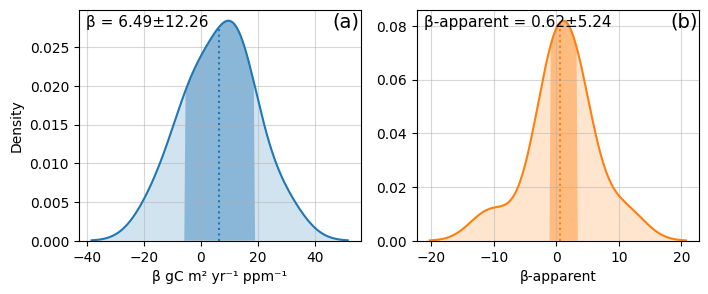

In [9]:
fig, ax = plt.subplots(1,2,figsize=(8, 3))
sb.kdeplot(data=ec_betas['β gC m² yr⁻¹ ppm⁻¹'], ax=ax[0],  color='tab:blue')
sb.kdeplot(data=ec_betas['β-apparent'], ax=ax[1],  color='tab:orange')
ax[1].set_ylabel(None)
ax[0].grid(alpha=0.5)
ax[1].grid(alpha=0.5)

kdeline = ax[0].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

middle = ec_betas['β gC m² yr⁻¹ ppm⁻¹'].mean()
sdev = ec_betas['β gC m² yr⁻¹ ppm⁻¹'].std()
left = middle - sdev
right = middle + sdev

# left, middle, right = np.percentile(ec_betas['β gC m² yr⁻¹ ppm⁻¹'], [25, 50, 75])
ax[0].vlines(middle, 0, np.interp(middle, xs, ys), color='tab:blue', ls=':')
ax[0].fill_between(xs, 0, ys, facecolor='tab:blue', alpha=0.2)
ax[0].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='tab:blue', alpha=0.4)

ax[0].text(.025, .925, f'\u03B2 = {middle:.2f}\u00B1{sdev:.2f}',
                transform=ax[0].transAxes, fontsize=11);

kdeline = ax[1].lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()

middle = ec_betas['β-apparent'].mean()
sdev = ec_betas['β-apparent'].std()
left = middle - sdev
right = middle + sdev

# left, middle, right = np.percentile(ec_betas['β-apparent'], [25, 50, 75])
ax[1].vlines(middle, 0, np.interp(middle, xs, ys), color='tab:orange', ls=':')
ax[1].fill_between(xs, 0, ys, facecolor='tab:orange', alpha=0.2)
ax[1].fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='tab:orange', alpha=0.4)

ax[1].text(.025, .925, f'\u03B2-apparent = {middle:.2f}\u00B1{sdev:.2f}',
                transform=ax[1].transAxes, fontsize=11);

ax[0].text(0.9, 0.925, '(a)',  transform=ax[0].transAxes, fontsize=14)
ax[1].text(0.9, 0.925, '(b)',  transform=ax[1].transAxes, fontsize=14)

fig.savefig(f"/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/eddycovariance_betas_residual_method_{model_var}",
            bbox_inches='tight', dpi=300)